In [3]:
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import savgol_filter
from scipy.stats import zscore

from tqdm import tqdm

import neuroseries as nts


import time
import matplotlib.pyplot as plt
# %matplotlib qt

import seaborn as sns 
import bk.load
import bk.compute
import bk.plot

import os
import cProfile


from fooof import FOOOF
from fooof.sim.gen import gen_aperiodic

In [4]:
import matplotlib as mpl
# COLOR = 'white'
# mpl.rcParams['text.color'] = COLOR
# mpl.rcParams['axes.labelcolor'] = COLOR
# mpl.rcParams['axes.edgecolor'] = COLOR
# mpl.rcParams['xtick.color'] = COLOR
# mpl.rcParams['ytick.color'] = COLOR
# mpl.rcParams['figure.facecolor'] = '#282C34'
# mpl.rcParams['axes.facecolor'] = '#282C34'
mpl.rcParams['svg.fonttype'] = 'none'
# %matplotlib qt

In [5]:
def compute_average_spec_state(base_folder,local_path = 'Rat08/Rat08-20130713',*args,**kwargs):
    if kwargs:
        stru = kwargs['stru']
        plot = kwargs['plot']
        save = kwargs['save']
        force_compute = kwargs['force_compute']
    
    file = f'Analysis/Power_spectrums/power_spectrum_{stru}.npy'
    

    bk.load.current_session_linux(base_folder = base_folder,local_path = local_path)
    if not force_compute:
        print('Try to load Data')
        if os.path.exists(file):
            return np.load(file,allow_pickle = True).ravel()[0]
    
    
    print('Stru set to ',stru)
    states = bk.load.states()
    pos = bk.load.pos_csv()
    speed = bk.compute.old_speed(pos,20)
    
    low_velocity = bk.compute.toIntervals(speed.index,speed.values<2)
    quiet_wake = states['wake'].intersect(low_velocity)
    quiet_wake = quiet_wake.merge_close_intervals(0.2,time_units = 's')
    quiet_wake = quiet_wake.drop_short_intervals(5,time_units = 's')

    states.update({'quiet_wake':quiet_wake})
    runintervals = bk.load.run_intervals()
    states.update({'run':runintervals})
    del states['drowsy'],states['wake']
    
    
    chan = bk.load.random_channel(stru)
    
    lfps = {}
    for s,interval in states.items():
        lfps.update({s:bk.load.lfp_in_intervals(chan,interval)})

    power_spectrum = {}
    for s,l in lfps.items():
        f,spec = scipy.signal.welch(l.values,fs=1250,nperseg=5000,noverlap=2500)
        power_spectrum.update({s:(f,spec)})
        
    if plot:
        plt.figure()
        for s,spec in power_spectrum.items():
            plot_power_spectrum(spec[0],spec[1],[0,100],True)
        plt.legend(power_spectrum.keys())
    
    if save:
        os.makedirs('Analysis/Power_spectrums/',exist_ok=True)
        np.save(file,power_spectrum)

    return power_spectrum

In [6]:
def flatten_spectrum(freqs,spectrum,freq_range):
    fm = FOOOF()
    fm.fit(freqs,spectrum,freq_range)
    init_ap_fit = init_ap_fit = gen_aperiodic(fm.freqs, fm._robust_ap_fit(fm.freqs, fm.power_spectrum))
    init_flat_spec = fm.power_spectrum - init_ap_fit

    return fm.freqs, init_flat_spec

In [19]:
def plot_power_spectrum(t,spec,xlim,log = True):
    if log: 
        plt.loglog(t,spec)
        plt.xlim(xlim)
    
def plot_average_power_spectrum(power,stru):
    col = ['orange','black','green','red']
    for (s,spec),c in zip(power.items(),col):
        f = spec[0]
        spec = spec[1]

        log_spec = np.log(spec)
        mean_log_spec = np.mean(log_spec,0)
        std_log_spec = np.std(log_spec,0)


        plt.semilogx(f,mean_log_spec,f'{c}')
#         plt.plot(f,mean_log_spec+std_log_spec,f'{c}',linestyle='dashed')
#         plt.plot(f,mean_log_spec-std_log_spec,f'{c}',linestyle='dashed')
        plt.fill_between(f,mean_log_spec+std_log_spec,mean_log_spec-std_log_spec,color=c,alpha = 0.2)
        plt.xlim([0,100])
        plt.ylim([2.5,13])
    plt.legend(power.keys())
    plt.xlabel('Frequency Hz')
    plt.ylabel('Power Spectrum(log)')
    plt.title(f'Power Spectrum In the {stru} \n n_session = {len(spec)}')


def plot_average_power_spectrum_FOOF(power,stru,ax = None):
    
    if ax is None:
        fig,ax = plt.subplots(1,1)
    
    freq_range = [2,200]
    col = ['orange','black','green','lime','red']
    for (s,spec),c in tqdm(zip(power.items(),col),total = len(col)):
        f = spec[0]
        spec = spec[1]
        spec_flat = []
        for u_spec in spec:
            f_flat,tmp_spec = flatten_spectrum(f,u_spec,freq_range)
            spec_flat.append(tmp_spec)

        mean_spec = np.mean(spec_flat,0)
        std_spec = np.std(spec_flat,0)


        ax.plot(f_flat,mean_spec,f'{c}')
#         plt.plot(f,mean_log_spec+std_log_spec,f'{c}',linestyle='dashed')
#         plt.plot(f,mean_log_spec-std_log_spec,f'{c}',linestyle='dashed')
        ax.fill_between(f_flat,mean_spec+std_spec,mean_spec-std_spec,color=c,alpha = 0.2)
    try:
        ax.set_title(f'Power Spectrum In the {stru} \n n_session = {len(spec)}')
    except:
        pass
    ax.legend(power.keys())

In [20]:
def merge(batch,metadata = None, rat = None):

    if metadata is not None:
        sessions = metadata.index[metadata['Rat'] == rat].values

    states = ['Rem','sws','quiet_wake','wake_homecage','run']
    power_spectrum = {}
    for s in states:
        av = []
        for sess,power_spec in batch.items():
            try:
                if sess not in sessions: continue
            except:
                pass
            av.append(power_spec[s][1])
            power_spectrum.update({s:(power_spec[s][0],av)})
    return power_spectrum

In [9]:
stru = ['Hpc','BLA']
batch = {}
metadata = {}

for s in stru:
    kwargs = {'stru': s,
            'plot': False,
            'save': True,
            'force_compute':False}

    batch_, metadata_ = bk.load.batch(
        compute_average_spec_state, local_base='/mnt/electrophy/Gabrielle/GG-Dataset-Light', **kwargs)
    batch.update({s:batch_})
    metadata.update({s:metadata_})

100%|██████████| 61/61 [00:14<00:00,  4.10it/s]

Batch finished in 14.897864818572998
Some session were not processed correctly
['Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140704', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
37.704918032786885 %


100%|██████████| 5/5 [00:19<00:00,  3.84s/it]


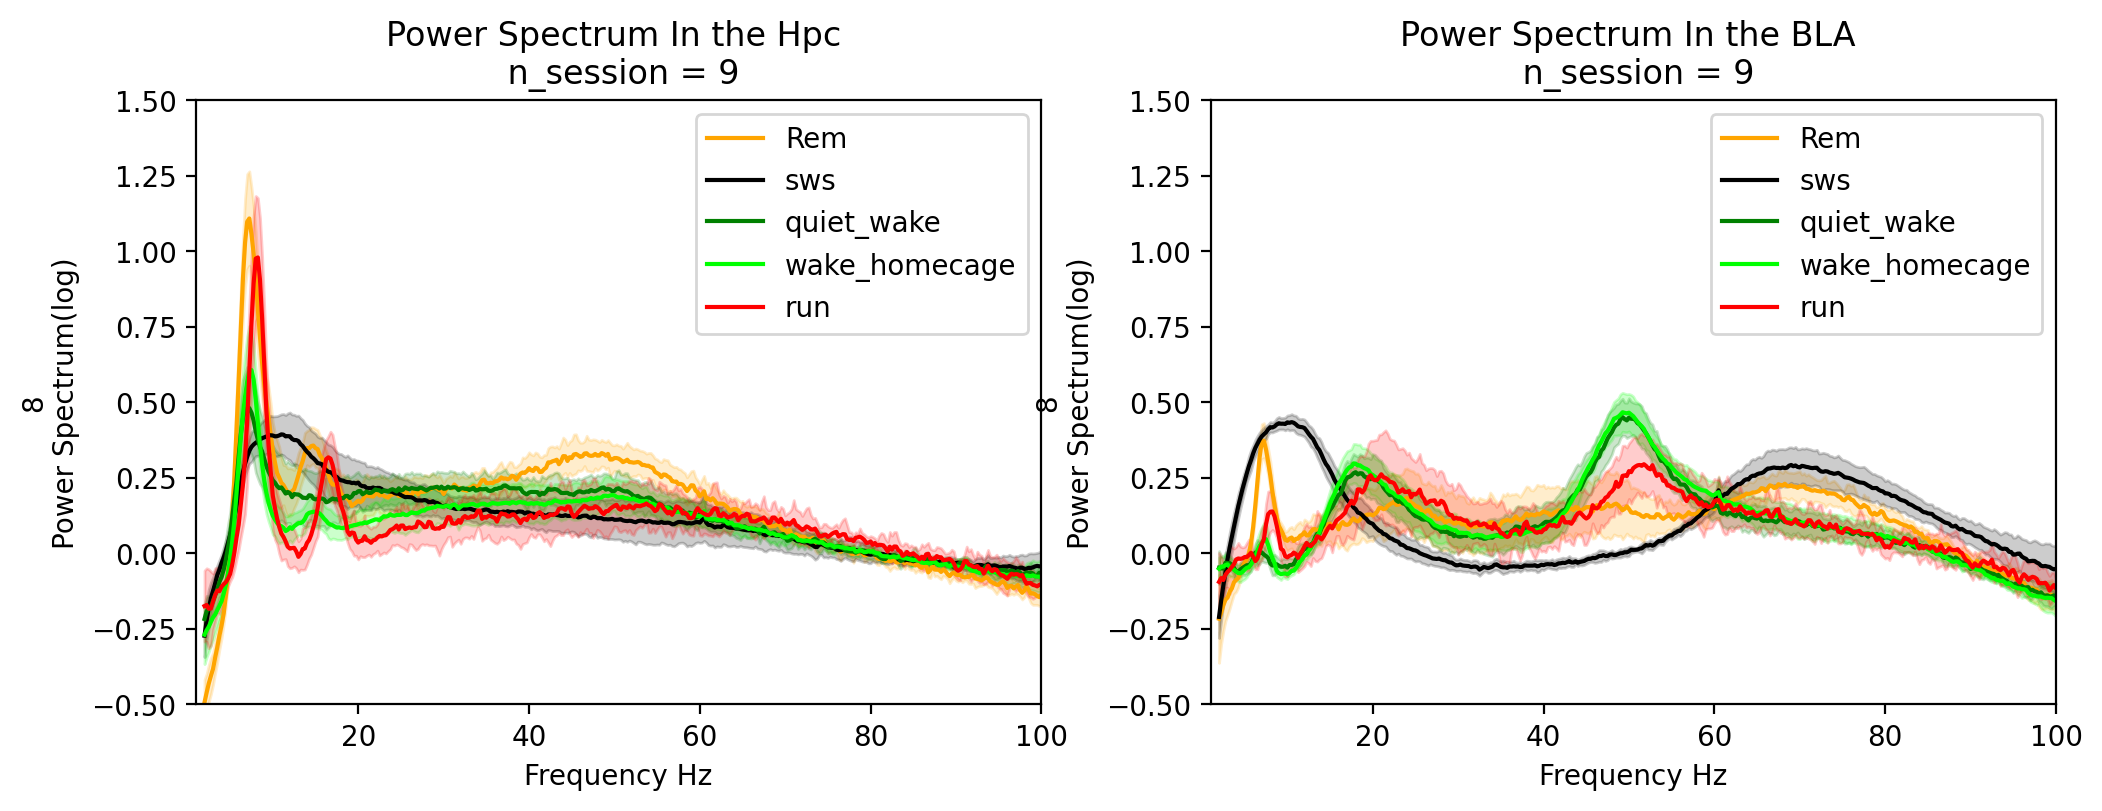

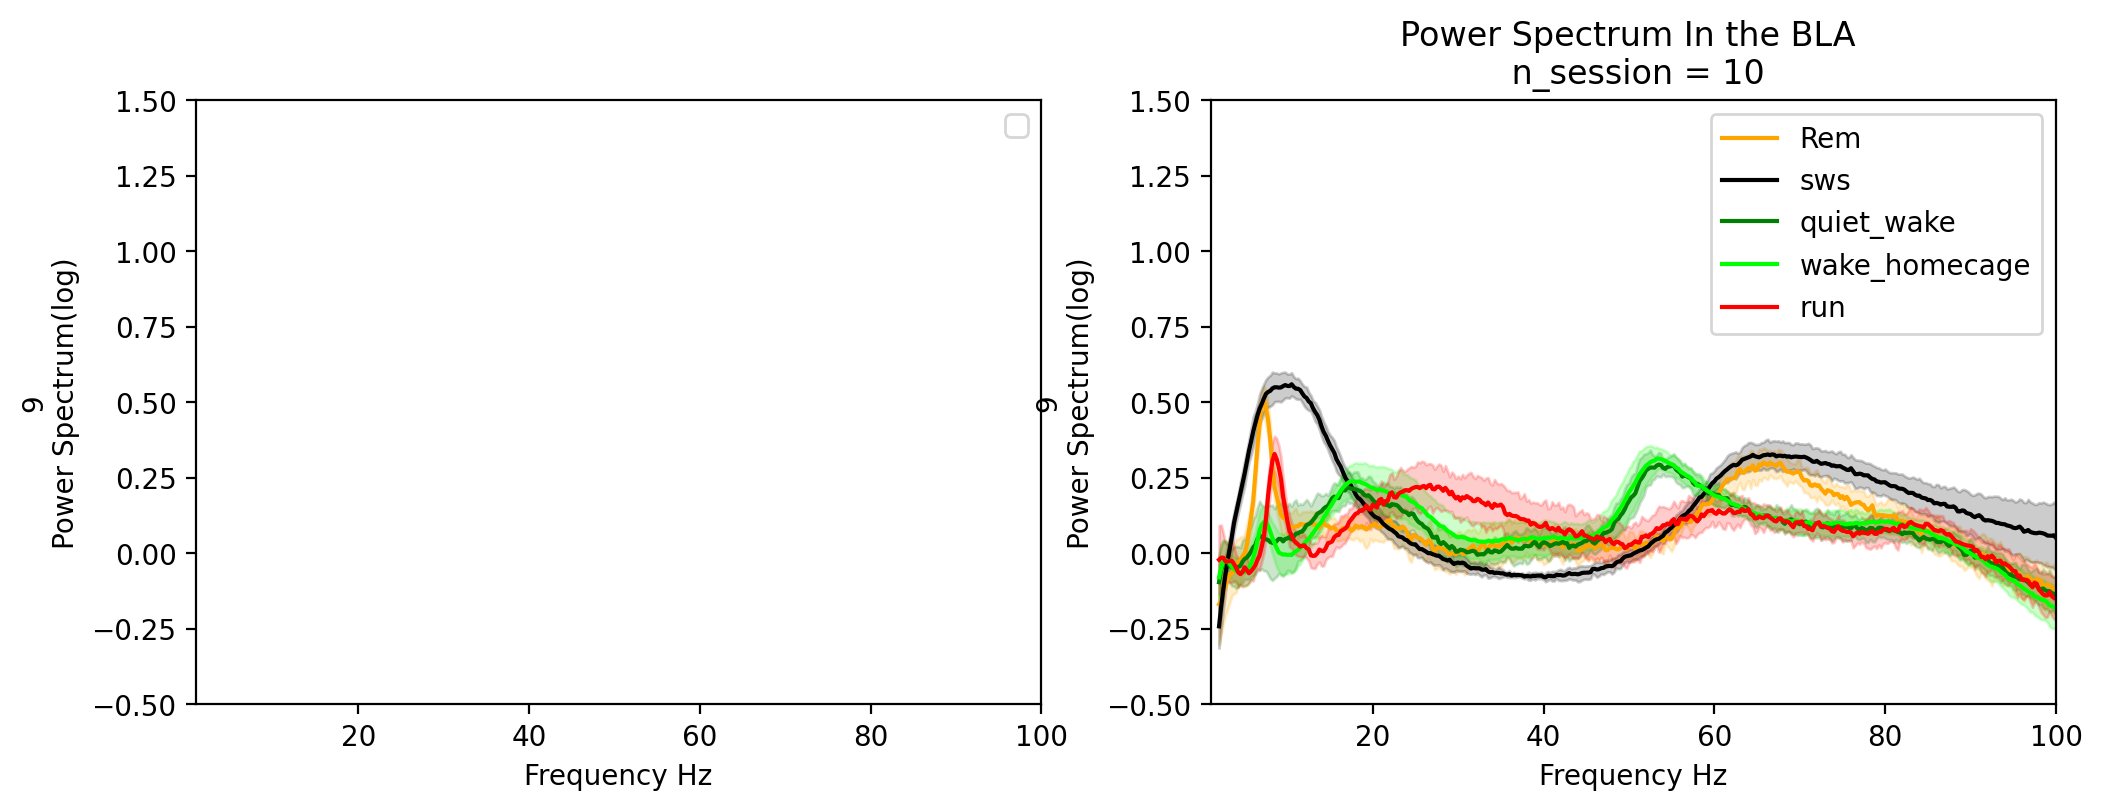

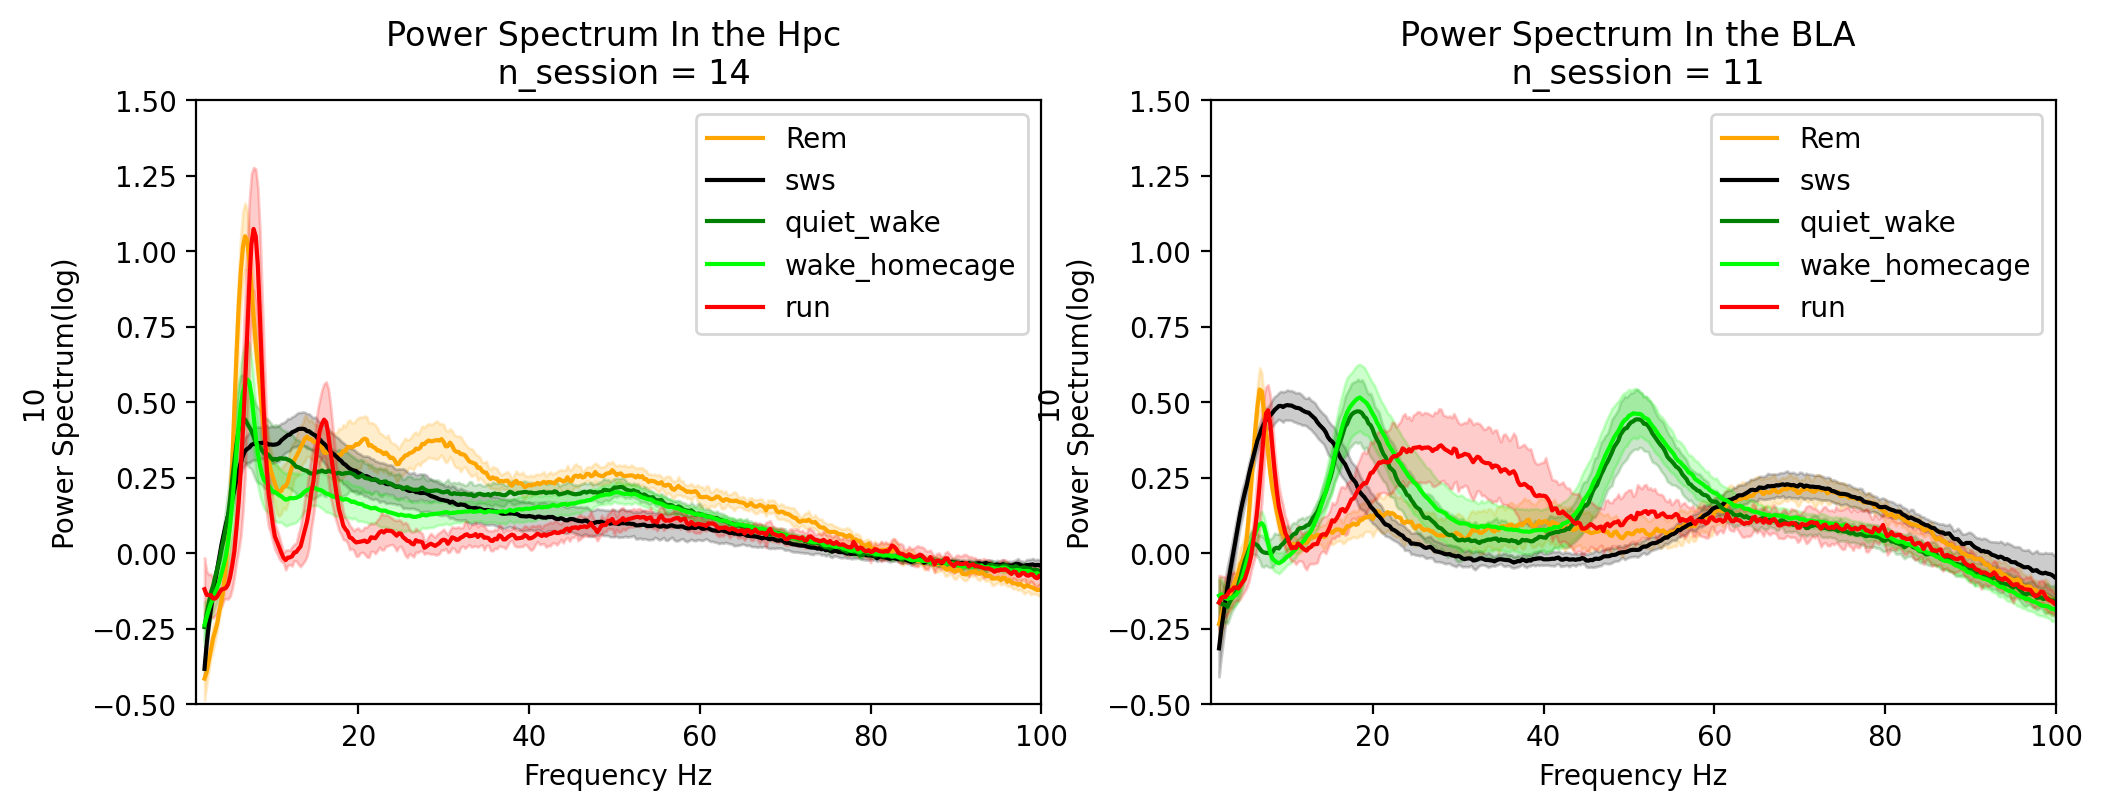

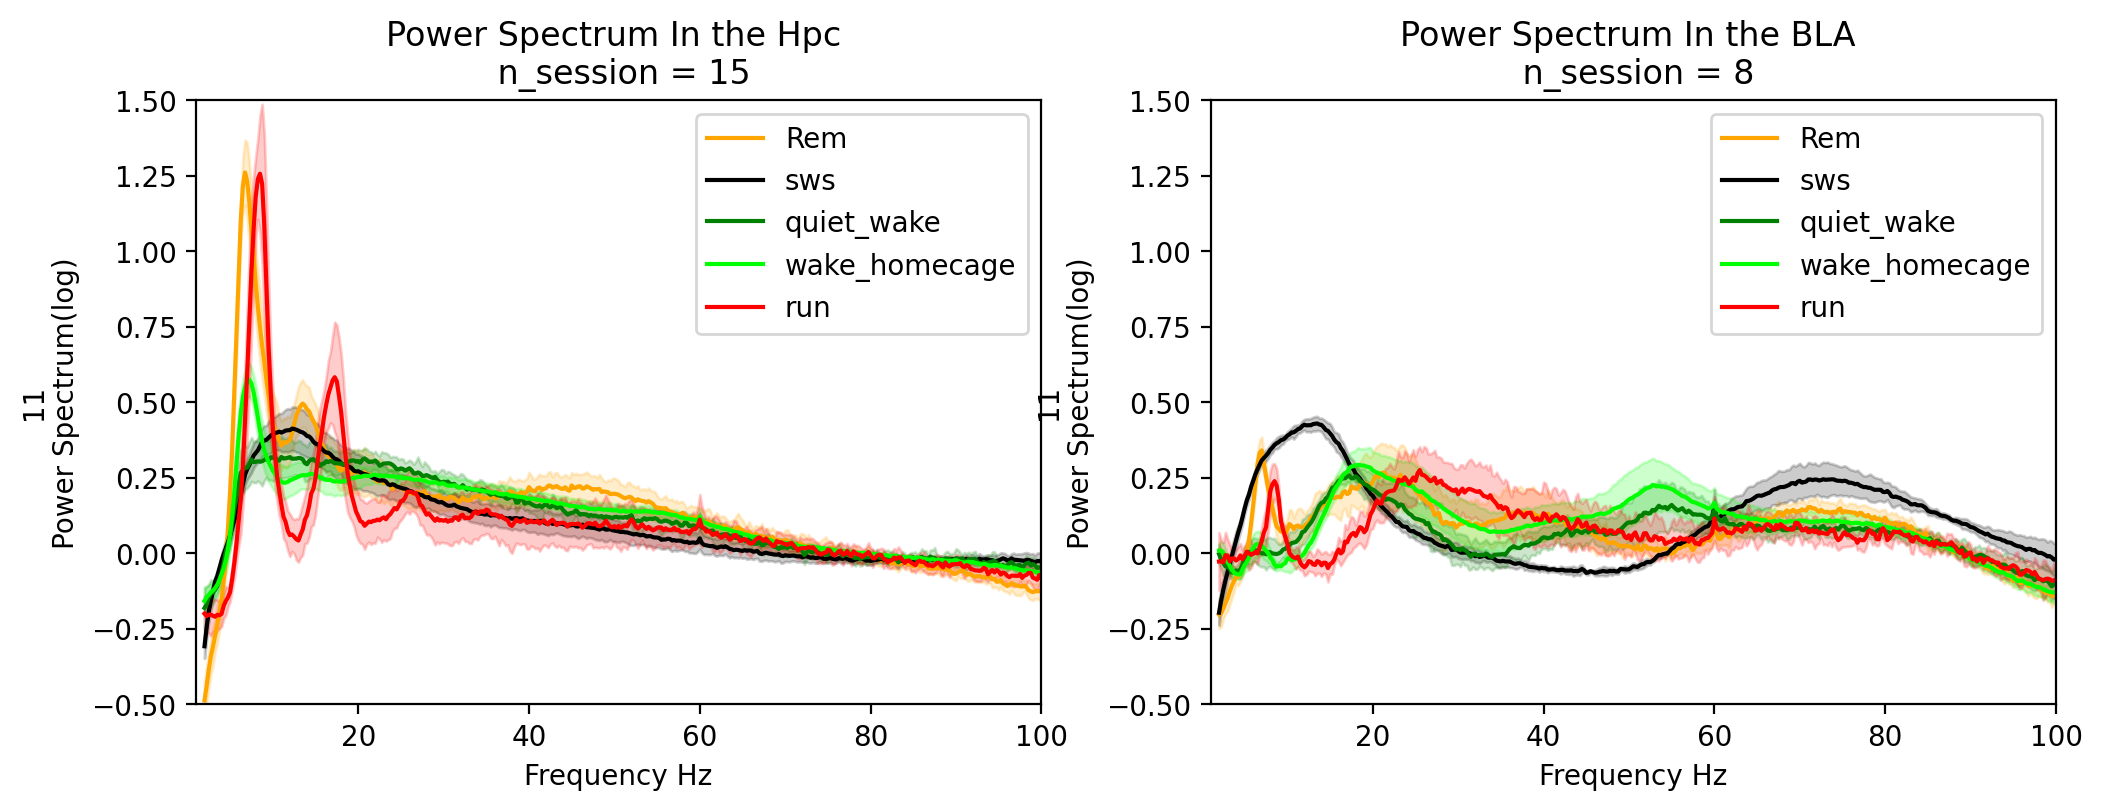

In [103]:
rats = [8,9,10,11]
for rat in rats:
    powers = {}
    for s in stru:
        powers.update({s:merge(batch[s],metadata[s],rat)})

    fig,ax = plt.subplots(1,2,figsize = (12,4),dpi = 200)

    for a,s in zip(ax,stru):
        plot_average_power_spectrum_FOOF(powers[s],s,a)
        a.set_xlim(1,100)
        a.set_ylim(-0.5,1.5)

        a.set_xlabel('Frequency Hz')
        a.set_ylabel(f'{rat}\nPower Spectrum(log)')
    fig.savefig(f'/home/billel/pCloudDrive/IFM/work/Figures/Figures_Gabrielle/PowerSpectrum/Flatten/{rat}_powerspectrums_states.svg')


In [13]:
powers

{'Hpc': {}, 'BLA': {}}

In [14]:
stru = ['Hpc','BLA']
for s in stru:
    powers.update({s:merge(batch[s],metadata[s])})


In [15]:
powers

{'Hpc': {}, 'BLA': {}}

100%|██████████| 5/5 [05:40<00:00, 68.16s/it]


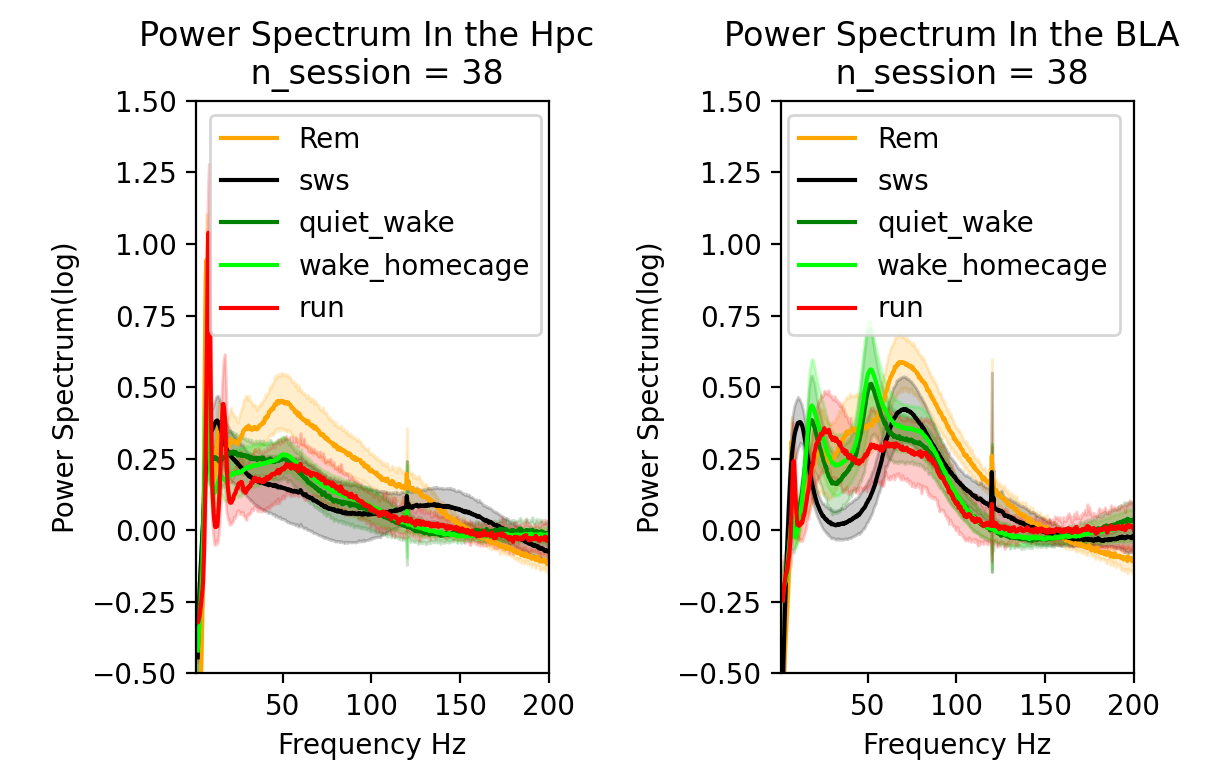

In [22]:
powers = {}
stru = ['Hpc','BLA']
for s in stru:
    powers.update({s:merge(batch[s])})

fig,ax = plt.subplots(1,2,dpi = 200)

for a,s in zip(ax,stru):
    plot_average_power_spectrum_FOOF(powers[s],s,a)
    a.set_xlim(1,200)
    a.set_ylim(-0.5,1.5)

    a.set_xlabel('Frequency Hz')
    a.set_ylabel(f'\nPower Spectrum(log)')
plt.tight_layout()
fig.savefig(f'/home/billel/pCloudDrive/IFM/work/Figures/Figures_Gabrielle/PowerSpectrum/Flatten/all(b)_powerspectrums_states.svg')